# A python parser for the BRENDA database

This project provides python classes and functions to parse the text file containing the entire BRENDA enzyme database (https://www.brenda-enzymes.org)

Due to BRENDA's license, BRENDA's database cannot be downloaded directly by the parser, instead, the user is asked to download the database as a text file after accepting usage conditions [here](https://www.brenda-enzymes.org/download_brenda_without_registration.php).

This is an ongoing project!

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from brendapyrser import BRENDA

dataFile = 'data/brenda_download.txt'

## 1. Parsing BRENDA

In [2]:
# Let's load the database
brenda = BRENDA(dataFile)
brenda

Number of Enzymes,7558
BRENDA copyright,"Copyrighted by Dietmar Schomburg, Techn. University Braunschweig, GERMANY. Distributed under the License as stated at http:/www.brenda-enzymes.org"
Parser version,0.0.1
Author,"Semidán Robaina Estévez, 2020"


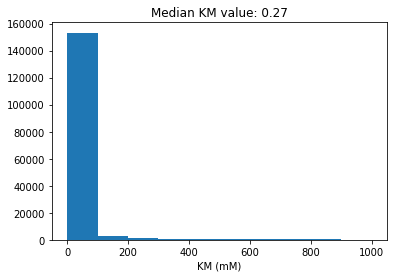

Minimum and maximum values in database: 0.0 mM, 999.8 mM


In [3]:
# Plot all Km values in the database
BRENDA_KMs = np.array([v for r in brenda.reactions 
                       for v in r.KMvalues.get_values()])
values = BRENDA_KMs[(BRENDA_KMs < 1000) & (BRENDA_KMs >= 0)]
plt.hist(values)
plt.title(f'Median KM value: {np.median(values)}')
plt.xlabel('KM (mM)')
plt.show()
print(f'Minimum and maximum values in database: {values.min()} mM, {values.max()} mM')

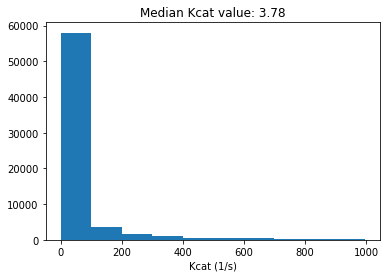

Minimum and maximum values in database: 5.83e-10 1/s, 997.0 1/s


In [4]:
# Plot all Km values in the database
BRENDA_Kcats = np.array([v for r in brenda.reactions 
                       for v in r.Kcatvalues.get_values()])
values = BRENDA_Kcats[(BRENDA_Kcats < 1000) & (BRENDA_Kcats >= 0)]
plt.hist(values)
plt.title(f'Median Kcat value: {np.median(values)}')
plt.xlabel('Kcat (1/s)')
plt.show()
print(f'Minimum and maximum values in database: {values.min()} 1/s, {values.max()} 1/s')

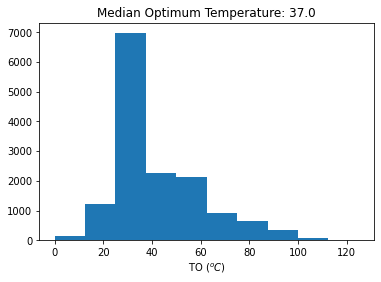

Minimum and maximum values in database: 0.0 °C, 125.0 °C


In [5]:
# Plot all enzyme optimal temperature values in the database
BRENDA_TO = np.array([v for r in brenda.reactions 
                       for v in r.temperature.filter_by_condition(
                           'optimum').get_values()])
values = BRENDA_TO[(BRENDA_TO >= 0)]
plt.hist(values)
plt.title(f'Median Optimum Temperature: {np.median(values)}')
plt.xlabel('TO (${}^oC$)')
plt.show()
print(f'Minimum and maximum values in database: {values.min()} °C, {values.max()} °C')

We see that the median optimal temperature for all enzymes in the BRENDA database is 37 °C! That's interesting... perhaps all organisms have agreed to prefer that temperature over other ones... or, more likely, it could be that BRENDA database is biased towards mammals and microorganisms that live within mammals... such as human pathogens.

Let's filter results for a particular species, let's try with a hyperthermophylic baterial genus, _Thermotoga_

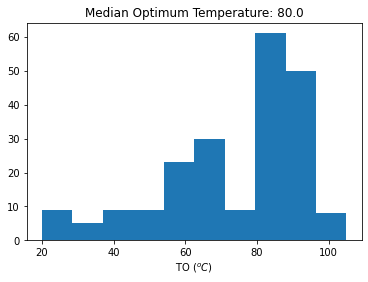

Minimum and maximum values in database: 20.0 °C, 105.0 °C


In [6]:
# Plot all enzyme optimal temperature values in the database
species = 'Thermotoga'
BRENDA_TO = np.array([v for r in brenda.reactions.filter_by_organism(species)
                       for v in r.temperature.filter_by_condition('optimum').filter_by_organism(species).get_values()])
values = BRENDA_TO[(BRENDA_TO >= 0)]
plt.hist(values)
plt.title(f'Median Optimum Temperature: {np.median(values)}')
plt.xlabel('TO (${}^oC$)')
plt.show()
print(f'Minimum and maximum values in database: {values.min()} °C, {values.max()} °C')

We can see that the median optimal temperature among all enzymes in the genus, 80°C, is much higher than in the case of the entire database. That's consistent with the fact that _Thermotoga_ are hyperthermophylic... alright!

## 2. Extracting data for _Pyruvate kinase_

In [7]:
# We can retrieve an enzyme entry by its EC number like this
r = brenda.reactions.get_by_id('2.7.1.40')
r

Enzyme identifier,2.7.1.40
Name,Pyruvate kinase
Systematic name,ATP:pyruvate 2-O-phosphotransferase
Reaction type,Phospho group transfer
Reaction,ATP + pyruvate <=> ADP + phosphoenolpyruvate


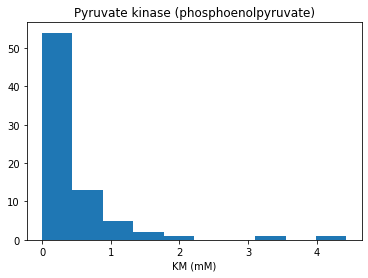

In [8]:
# Here are all the KM values for phosphoenolpyruvate associated with this enzyme class
compound = 'phosphoenolpyruvate'
kms = r.KMvalues.filter_by_compound(compound).get_values()
plt.hist(kms)
plt.xlabel('KM (mM)')
plt.title(f'{r.name} ({compound})')
plt.show()

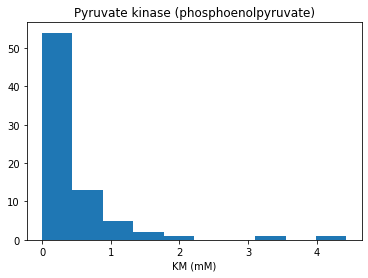

In [9]:
# Here are all the KM values for phosphoenolpyruvate associated with this enzyme class
compound = 'phosphoenolpyruvate'
KMs = r.KMvalues.filter_by_compound(compound).get_values()
plt.hist(KMs)
plt.xlabel('KM (mM)')
plt.title(f'{r.name} ({compound})')
plt.show()

In [10]:
# And further filtered by organism
r.KMvalues.filter_by_organism('Bos taurus').filter_by_compound('phosphoenolpyruvate').get_values()

[0.051500000000000004, 0.18]

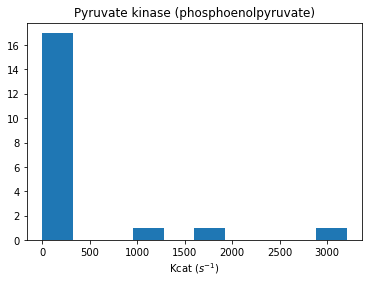

In [11]:
# Here are all the Kcat values for phosphoenolpyruvate associated with this enzyme class
compound = 'phosphoenolpyruvate'
kcats = r.Kcatvalues.filter_by_compound(compound).get_values()
plt.hist(kcats)
plt.xlabel('Kcat ($s^{-1}$)')
plt.title(f'{r.name} ({compound})')
plt.show()

In [12]:
r.substratesAndProducts   

[{'substrates': ['AKT1S1', 'ATP'], 'products': ['ADP', 'phospho-AKT1S1']},
 {'substrates': ['TDP', 'phosphoenolpyruvate'],
  'products': ['TTP', 'pyruvate | 95% yield |']},
 {'substrates': ['ATP', 'pyruvate'],
  'products': ['ADP', 'phosphoenolpyruvate']},
 {'substrates': ['ADP', 'phosphoenolpyruvate'],
  'products': ['ATP', 'pyruvate']},
 {'substrates': ['ATP', 'prothymosin alpha'],
  'products': ['ADP', 'phospho-prothymosin alpha']}]

## 3 Finding all KM values for a given substrate and organism
Next, we will retrieve KM values associated to a particular substrate for all enzymes in a given species. Will t he KM values distribute around a narrow or wider concentration range? Since substrate concentration in cytoplasma is the same for all enzymes it makes sense that all cytoplasmi enzymes utilizing that substrate have similar KM values. Let's test this idea with _Escherichia coli_ and some common substrates participating in the central carbon metabolism.

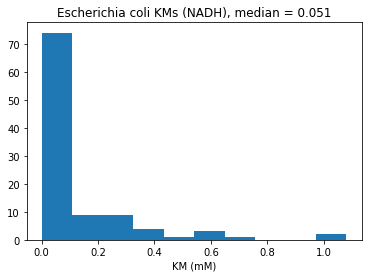

In [13]:
species, compound = 'Escherichia coli', 'NADH'
KMs = np.array([v for r in brenda.reactions.filter_by_organism(species)
                for v in r.KMvalues.filter_by_compound(compound).filter_by_organism(species).get_values()])

if len(KMs) > 0:
    plt.hist(KMs)
    plt.xlabel('KM (mM)')
    plt.title(f'{species} KMs ({compound}), median = {np.median((KMs))}')
    plt.show()
else:
    print('No KM values for compound')

That's interesting! typical NADH concentrations are low in _Escherichia coli_, e.g., from [BioNumbers](http://book.bionumbers.org/what-are-the-concentrations-of-free-metabolites-in-cells/) we get a value of 0.083 mM. The median KM value for NADH among all enzymes binding it is lower as we see in the plot above! Hence, it looks like most enzymes are (nearly) saturated for NADH and thus fluxes are sort of independent of NADH concentration.